# Automatidata: New York City TLC  Customers classification model 

# We are using the **PACE** strategy which acts as a framework to simplify the process of building a machine learning model , 
# PACE classify the whole project to 4 stages :
  - ### Plan
  - ### Analyze
  - ### Construct
  - ### Execute

## **Pace: Plan**

###  The business scenario and problem

Automatidata works with its clients to transform their unused and stored data into useful solutions, such as performance dashboards, customer-facing tools, strategic business insights, and more. They specialize in identifying a client’s business needs and utilizing their data to meet those business needs. 

Automatidata is consulting for the New York City Taxi and Limousine Commission (TLC). New York City TLC is an agency responsible for licensing and regulating New York City's taxi cabs and for-hire vehicles. 
**The agency has partnered with Automatidata to develop a classification model that helps classify customers as generous or not according to their tips.**

###  Evaluation Metric

Now which of these accuracy measures should we care about ? it depends on what we want the model to achieve.

**Accuracy** is a straight forward metric , but it may not be the most suitable metric in scenarios with imbalanced datasets , like the one we have her

**Precision** is useful when the cost of **false positives** is high.

**Recall** is useful when the cost of **false negatives** is high.

**f1-score**  is useful when there is an uneven class distribution or when there is an equal emphasis on both false positives and false negatives.

To determine which evaluation metric might be best, we should consider how the model might be wrong. There are two possibilities for bad predictions:

  - **False positives:** When the model predicts a tip ≥ 20%, but the customer does not give one
  - **False negatives:** When the model predicts a tip < 20%, but the customer gives more
  
**False positives** are worse for cab drivers, because they would pick up a customer expecting a good tip and then not receive one, frustrating the driver.

**False negatives** are worse for customers, because a cab driver would likely pick up a different customer who was predicted to tip more even when the original customer would have tipped generously. 

**We want to help taxi drivers make more money, but we don't want this to anger customers. our metric should weigh both precision and recall equally. this metric is F1-score.

## Step 1. Imports

### Import packages

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics  import confusion_matrix , ConfusionMatrixDisplay
from sklearn.metrics import precision_score  , recall_score , accuracy_score, f1_score
from sklearn.model_selection import train_test_split , GridSearchCV ,  PredefinedSplit

### Load dataset


**There are two datasets we want to import, one is the original dataset for New York City TLC , and the othe contains the mean durations, mean distances, and predicted fares**

In [2]:
# Load the main dataset
df0 = pd.read_csv("Yellow_Taxi_Trip_Data.csv")

#Load the other dataset that contains the mean durations, mean distances, and predicted fares
df1 = pd.read_csv("nyc_preds_means.csv")

In [3]:
# Display first few rows of the main dataset
df0.head(10)

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80
5,23345809,2,03/25/2017 8:34:11 PM,03/25/2017 8:42:11 PM,6,2.30,1,N,161,236,1,9.0,0.5,0.5,2.06,0.0,0.3,12.36
6,37660487,2,05/03/2017 7:04:09 PM,05/03/2017 8:03:47 PM,1,12.83,1,N,79,241,1,47.5,1.0,0.5,9.86,0.0,0.3,59.16
7,69059411,2,08/15/2017 5:41:06 PM,08/15/2017 6:03:05 PM,1,2.98,1,N,237,114,1,16.0,1.0,0.5,1.78,0.0,0.3,19.58
8,8433159,2,02/04/2017 4:17:07 PM,02/04/2017 4:29:14 PM,1,1.20,1,N,234,249,2,9.0,0.0,0.5,0.00,0.0,0.3,9.80
9,95294817,1,11/10/2017 3:20:29 PM,11/10/2017 3:40:55 PM,1,1.60,1,N,239,237,1,13.0,0.0,0.5,2.75,0.0,0.3,16.55


In [4]:
# Display first few rows of the other dataset
df1.head(10)

,mean_duration,mean_distance,predicted_fare
0,22.847222,3.521667,16.434245
1,24.470370,3.108889,16.052218
2,7.250000,0.881429,7.053706
3,30.250000,3.700000,18.731650
4,14.616667,4.435000,15.845642
5,11.855376,2.052258,10.441351
6,59.633333,12.830000,45.374542
7,26.437500,4.022500,18.555128
8,7.873457,1.019259,7.151511
9,10.541111,1.580000,9.122755


**let's join the two datasets together into one dataset**

In [5]:
# Merge datasets
df0 = df0.merge(df1,
                left_index=True,
                right_index=True)

df0.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,...,13.0,0.0,0.5,2.76,0.0,0.3,16.56,22.847222,3.521667,16.434245
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,...,16.0,0.0,0.5,4.00,0.0,0.3,20.80,24.470370,3.108889,16.052218
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,...,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.250000,0.881429,7.053706
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,...,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.250000,3.700000,18.731650
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,...,16.5,0.5,0.5,0.00,0.0,0.3,17.80,14.616667,4.435000,15.845642


## Step 2. Data Exploration (Initial EDA and data cleaning)

### identifying number of rows and columns in the dataset

In [6]:
df0.shape

(22699, 21)

### basic information about the data

In [7]:
# Gather basic information about the data
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

### descriptive statistics about the data

In [8]:
# Gather descriptive statistics about the data
df0.describe()

,Unnamed: 0,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,mean_duration,mean_distance,predicted_fare
count,2.269900e+04,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000,22699.000000
mean,5.675849e+07,1.556236,1.642319,2.913313,1.043394,162.412353,161.527997,1.336887,13.026629,0.333275,0.497445,1.835781,0.312542,0.299551,16.310502,14.460555,2.913313,12.979534
std,3.274493e+07,0.496838,1.285231,3.653171,0.708391,66.633373,70.139691,0.496211,13.243791,0.463097,0.039465,2.800626,1.399212,0.015673,16.097295,10.080913,3.558993,9.706126
min,1.212700e+04,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,-120.000000,-1.000000,-0.500000,0.000000,0.000000,-0.300000,-120.300000,0.000000,0.000000,2.934494
25%,2.852056e+07,1.000000,1.000000,0.990000,1.000000,114.000000,112.000000,1.000000,6.500000,0.000000,0.500000,0.000000,0.000000,0.300000,8.750000,8.031481,1.010000,7.396030
50%,5.673150e+07,2.000000,1.000000,1.610000,1.000000,162.000000,162.000000,1.000000,9.500000,0.000000,0.500000,1.350000,0.000000,0.300000,11.800000,11.556667,1.620000,9.560801
75%,8.537452e+07,2.000000,2.000000,3.060000,1.000000,233.000000,233.000000,2.000000,14.500000,0.500000,0.500000,2.450000,0.000000,0.300000,17.800000,17.321667,3.115625,13.933373
max,1.134863e+08,2.000000,6.000000,33.960000,99.000000,265.000000,265.000000,4.000000,999.990000,4.500000,0.500000,200.000000,19.100000,0.300000,1200.290000,88.783333,33.920000,89.171050


### Check missing values

Check for any missing values in the data.

In [ ]:
# Check for missing values
df0.isnull().sum()

### Check duplicates

Check for any duplicate entries in the data.

In [ ]:
# Check for duplicates
df0.duplicated().sum()

### Check outliers

We are going to use Naivebaise and tree based models in our experiments , which are robust to outliers so no need to drop them.

# pAce: Analyze Stage

### Feature Engineering

Previous EDA showed that customers who pay cash generally have a tip amount of $0. so To meet the modeling objective, we'll need to sample the data to select only the customers who pay with credit card.

In [9]:
# Subset the data to isolate only customers who paid by credit card
df1 = df0[df0['payment_type']==1]

##### **Target**

**Now there isn't a column that indicates tip percent, which is what we need to create the **target variable**. we should have to engineer it ourselves.** 

let's Add a `tip_percent` column to the dataframe by performing the following calculation:  
<br/>  


$$tip\ percent = \frac{tip\ amount}{total\ amount - tip\ amount}$$  

We should Round the result to three places beyond the decimal. **This is an important step.** as It affects how many customers are labeled as generous tippers. In fact, without performing this step, approximately 1,800 people who do tip ≥ 20% would be labeled as not generous. 

To understand why, let's consider how floats work. Computers make their calculations using floating-point arithmetic . Floating-point arithmetic is a system that allows computers to express both very large numbers and very small numbers with a high degree of precision, encoded in binary. However, precision is limited by the number of bits used to represent a number, which is generally 32 or 64, depending on the capabilities of our operating system. 

This comes with limitations in that sometimes calculations that should result in clean, precise values end up being encoded as very long decimals.

In [10]:
# Create tip % col
df2 = df1.copy()

df2['tip_percent'] = round(df1['tip_amount'] / (df1['total_amount'] - df1['tip_amount']), 3)

Now let's create another column called `generous`. This will be the target variable. The column should be a binary indicator of whether or not a customer tipped ≥ 20% (0=no, 1=yes).

1. Begin by making the `generous` column a copy of the `tip_percent` column.
2. Reassign the column by converting it to Boolean (True/False).
3. Reassign the column by converting Boolean to binary (1/0).

In [11]:
# Create 'generous' col (target)
df2['generous'] = df2['tip_percent']
df2['generous'] = (df2['generous'] >= 0.2)
df2['generous'] = df2['generous'].astype(int)

Next, we're going to work with the pickup and dropoff columns.

so let's Convert the `tpep_pickup_datetime` and `tpep_dropoff_datetime` columns to datetime.

In [12]:
# Convert pickup and dropoff cols to datetime
df2['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
df2['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

Now let's Create a `day` column that contains only the day of the week when each passenger was picked up. Then, convert the values to lowercase.

In [13]:
# Create a 'day' col
df2['day'] = df2['tpep_pickup_datetime'].dt.day_name().str.lower()

Next,let's  engineer four new columns that represent time of day bins. Each column should contain binary values (0=no, 1=yes) that indicate whether a trip began (picked up) during the following times:

am_rush = [06:00–10:00)

daytime = [10:00–16:00)

pm_rush = [16:00–20:00)

nighttime = [20:00–06:00)


In [14]:
# Create 'am_rush' col
df2['am_rush'] = df2['tpep_pickup_datetime'].dt.hour

# Create 'daytime' col
df2['daytime'] = df2['tpep_pickup_datetime'].dt.hour

# Create 'pm_rush' col
df2['pm_rush'] = df2['tpep_pickup_datetime'].dt.hour

# Create 'nighttime' col
df2['nighttime'] = df2['tpep_pickup_datetime'].dt.hour

Now let's write four functions to convert each new column to binary (0/1).

In [15]:
# Define 'am_rush()' conversion function [06:00–10:00)
def am_rush(hour):
    if 6 <= hour['am_rush'] < 10:
        val = 1
    else:
        val = 0
    return val

Now, let's apply the `am_rush()` function to the `am_rush` series to perform the conversion.

**we should be careful that if this cell is run twice, the function will be reapplied and the values will all be changed to 0.**

In [16]:
# Apply 'am_rush' function to the 'am_rush' series
df2['am_rush'] = df2.apply(am_rush, axis=1)

#check that the function is applied successfully
df2['am_rush'].head()

0    1
1    0
2    1
3    0
5    0
Name: am_rush, dtype: int64

Now Let's Write the three remaining functions to convert the three remaining columns and apply them to their respective series.

In [17]:
# Define 'daytime()' conversion function [10:00–16:00)
def daytime(hour):
    if 10 <= hour['daytime'] < 16:
        val = 1
    else:
        val = 0
    return val

In [18]:
# Apply 'daytime' function to the 'daytime' series
df2['daytime'] = df2.apply(daytime, axis=1)

#check that the function is applied successfully
df2['daytime'].head()

0    0
1    1
2    0
3    1
5    0
Name: daytime, dtype: int64

In [19]:
# Define 'pm_rush()' conversion function [16:00–20:00)
def pm_rush(hour):
    if 16 <= hour['pm_rush'] < 20:
        val = 1
    else:
        val = 0
    return val

In [20]:
# Apply 'pm_rush' function to the 'pm_rush' series
df2['pm_rush'] = df2.apply(pm_rush, axis=1)

#check that the function is applied successfully
df2['pm_rush'].head()

0    0
1    0
2    0
3    0
5    0
Name: pm_rush, dtype: int64

In [21]:
# Define 'nighttime()' conversion function [20:00–06:00)
def nighttime(hour):
    if 20 <= hour['nighttime'] < 24:
        val = 1
    elif 0 <= hour['nighttime'] < 6:
        val = 1
    else:
        val = 0
    return val

In [22]:
# Apply 'nighttime' function to the 'nighttime' series
df2['nighttime'] = df2.apply(nighttime, axis=1)

#check that the function is applied successfully
df2['nighttime'].head()

0    0
1    0
2    0
3    0
5    1
Name: nighttime, dtype: int64

Now, let's create a `month` column that contains only the abbreviated name of the month when each passenger was picked up, then convert the result to lowercase.

In [23]:
# Create 'month' col
df2['month'] = df2['tpep_pickup_datetime'].dt.strftime('%b').str.lower()

let's have a look at the dataset after engineering !

In [24]:
df2.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,mean_distance,predicted_fare,tip_percent,generous,day,am_rush,daytime,pm_rush,nighttime,month
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,N,100,231,...,3.521667,16.434245,0.200,1,saturday,1,0,0,0,mar
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,N,186,43,...,3.108889,16.052218,0.238,1,tuesday,0,1,0,0,apr
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,N,262,236,...,0.881429,7.053706,0.199,0,friday,1,0,0,0,dec
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,N,188,97,...,3.700000,18.731650,0.300,1,sunday,0,1,0,0,may
5,23345809,2,2017-03-25 20:34:11,2017-03-25 20:42:11,6,2.30,1,N,161,236,...,2.052258,10.441351,0.200,1,saturday,0,0,0,1,mar


Now let's Drop redundant and irrelevant columns as well as those that would not be available when the model is deployed. This includes information like payment type, trip distance, tip amount, tip percentage, total amount, toll amount, etc. The target variable (`generous`) must remain in the data because it will get isolated as the `y` data for modeling.

In [25]:
# Drop columns
drop_cols = ['Unnamed: 0', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
             'payment_type', 'trip_distance', 'store_and_fwd_flag', 'payment_type',
             'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
             'improvement_surcharge', 'total_amount', 'tip_percent']

df2 = df2.drop(drop_cols, axis=1)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15265 entries, 0 to 22698
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         15265 non-null  int64  
 1   passenger_count  15265 non-null  int64  
 2   RatecodeID       15265 non-null  int64  
 3   PULocationID     15265 non-null  int64  
 4   DOLocationID     15265 non-null  int64  
 5   mean_duration    15265 non-null  float64
 6   mean_distance    15265 non-null  float64
 7   predicted_fare   15265 non-null  float64
 8   generous         15265 non-null  int32  
 9   day              15265 non-null  object 
 10  am_rush          15265 non-null  int64  
 11  daytime          15265 non-null  int64  
 12  pm_rush          15265 non-null  int64  
 13  nighttime        15265 non-null  int64  
 14  month            15265 non-null  object 
dtypes: float64(3), int32(1), int64(9), object(2)
memory usage: 1.8+ MB


### Check class balance

understanding how many customers are generous and how many are not generous

In [26]:
# Get numbers of people who are generous vs. not generous
df2['generous'].value_counts()
# Get percentages of people who left vs. stayed
df2['generous'].value_counts(normalize = True) *100

1    52.636751
0    47.363249
Name: generous, dtype: float64

<Axes: >

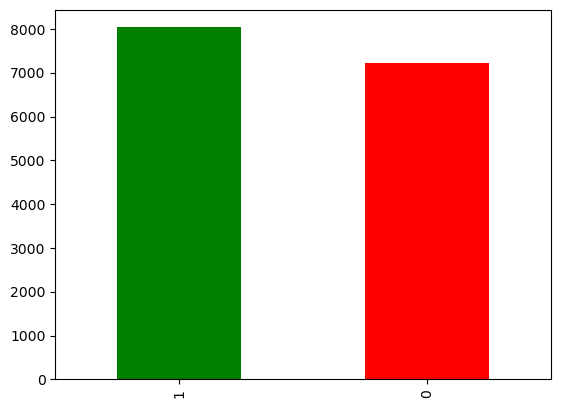

In [27]:
#visualizing class balance
df2['generous'].value_counts().plot.bar(color=['green', 'red'])

Great , the target variable is balanced

### Variable Encoding

Many of the columns are categorical and will need to be dummied (converted to binary). Some of these columns are numeric, but they actually encode categorical information, such as `RatecodeID` and the pickup and dropoff locations. To make these columns recognizable to the `get_dummies()` function as categorical variables, we'll first need to convert them to `type(str)`. 

1. Define a variable called `cols_to_str`, which is a list of the numeric columns that contain categorical information and must be converted to string: `RatecodeID`, `PULocationID`, `DOLocationID`.
2. Write a for loop that converts each column in `cols_to_str` to string.

In [ ]:
# 1. Define list of cols to convert to string
cols_to_str = ['RatecodeID', 'PULocationID', 'DOLocationID', 'VendorID']

# 2. Convert each column to string
for col in cols_to_str:
    df2[col] = df2[col].astype('str')

Now convert all the categorical columns to binary.

In [31]:
# Convert categoricals to binary
df2 = pd.get_dummies(df2, drop_first=True)
df2.head()

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,mean_duration,mean_distance,predicted_fare,generous,am_rush,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,2,6,1,100,231,22.847222,3.521667,16.434245,1,1,...,0,0,0,0,0,1,0,0,0,0
1,1,1,1,186,43,24.470370,3.108889,16.052218,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,262,236,7.250000,0.881429,7.053706,0,1,...,1,0,0,0,0,0,0,0,0,0
3,2,1,1,188,97,30.250000,3.700000,18.731650,1,0,...,0,0,0,0,0,0,1,0,0,0
5,2,6,1,161,236,11.855376,2.052258,10.441351,1,0,...,0,0,0,0,0,1,0,0,0,0


# paCe: Construct Stage

## Step 3. Model Building

This is a classification task , since our target variable is categorical consisting of 0 and 1. 

we will proceed with three classifiers:
 - Naive Bayes
 - Random Forest
 - XGBOOST

### Modeling

In [32]:
# Identifying features and target variable
X = df2.drop(['generous'] , axis = 1)
y = df2['generous']

X.head()

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,mean_duration,mean_distance,predicted_fare,am_rush,daytime,...,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep
0,2,6,1,100,231,22.847222,3.521667,16.434245,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,1,1,186,43,24.470370,3.108889,16.052218,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,262,236,7.250000,0.881429,7.053706,1,0,...,1,0,0,0,0,0,0,0,0,0
3,2,1,1,188,97,30.250000,3.700000,18.731650,0,1,...,0,0,0,0,0,0,1,0,0,0
5,2,6,1,161,236,11.855376,2.052258,10.441351,0,0,...,0,0,0,0,0,1,0,0,0,0


In [33]:
# Split dataset into training , validating holdout(test) datasets

#creating Training and testing sets
X_train , X_test , y_train , y_test = train_test_split(X, y , test_size = 0.3 , stratify=y , random_state = 42)

#creating a validation set
X_tr , X_val , y_tr , y_val = train_test_split(X_train, y_train , test_size = 0.5,  stratify=y_train , random_state = 10)

Let's illustrate what we are doing here , simply we are splitting our dataset to training and testing set as normal , but we want to apply the **cross validation** technique , which means that we will train our model using the training data as normal , but we won't check the model accuracy on the test data , instead we will use our validation set to train all the models we are going to experiment.
now the question is what should be done with the test data 🤔 ????!
the test data will remain unseen until we finish building all the models , finally the champion model (the model with higher accuracy scores) will only be used to predict on the testing data 😎.
the following diagram illustrates the idea. 

Note: it's not a must to split the data 60 20 20 , in our case here , we are splitting it to 70 15 15

![optimal_model_flow_numbered](Images/optimal_model_flow_numbered.svg)

## Experiment 1: Naive Bayes

There are different types of Naive bayes algorithms to be used here , they are :

**BernoulliNB**: Used for binary/Boolean features 

**CategoricalNB**: Used for categorical features

**ComplementNB**: Used for imbalanced datasets, often for text classification tasks

**GaussianNB**: Used for continuous features, normally distributed features

**MultinomialNB**: Used for multinomial (discrete) features

Since our features are continous , we will use gaussian NB

In [34]:
# Training a Naive Bayes Classifier
Naive_model = GaussianNB().fit(X_train , y_train)

#### We are going to use the confusion matrix & accuracy measures to test the accuracy of each model we will create , so let's create a function that takes three arguments , model , x_data and y_data , to prevent code duplication

In [35]:
#creating a confusion matrix to identify how accurate our classifier is
def conf_matrix_plot(model, x_data, y_data):
    model_pred = model.predict(x_data) # Save predictions
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_) # Calculate the values for each quadrant in the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
    disp.plot(values_format='')  # `values_format=''` this is written to prevent the numbers in the confusion matrix to appear in that form (1.5e+03) 
    plt.show()    
    
    #Accuracy reports
    report =    {"Accuracy" :accuracy_score(y_data, model_pred) , 
                "Precision": precision_score(y_data, model_pred),
                "Recall" : recall_score(y_data, model_pred) , 
                "F1 Score" : f1_score(y_data, model_pred)}
    for key , value  in report.items():
        print(f"{key}:{value.round(3)}")

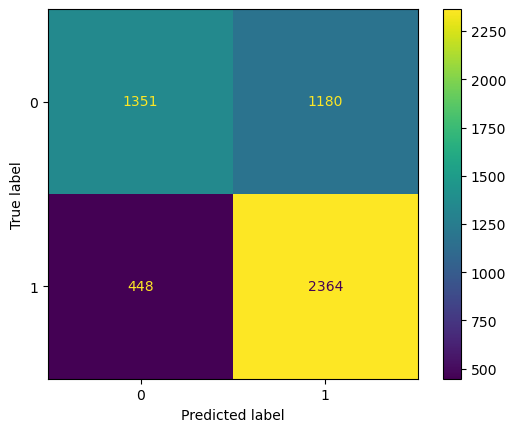

Accuracy:0.695
Precision:0.667
Recall:0.841
F1 Score:0.744


In [36]:
conf_matrix_plot(Naive_model, X_val, y_val)

## Experiment 2: Random Forest

#### We should first first identify the best Hyper paramaters for the classifier using GridSearch

In [37]:
# Instantiate random forest model.
rf = RandomForestClassifier()

In [38]:
# Determine set of hyperparameters for random forest
rf_cv_params = {'n_estimators' : [50,100 , 150 , 200], 
              'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50],
             'min_samples_split': [2, 4, 6],
              'max_features' : ["sqrt"], 
              'max_samples' : [.5,.9]}

scoring = {'accuracy', 'precision', 'recall', 'f1'}

GridSearchCV wants to cross validate the data. In fact, if the CV parameter was left blank, it would split the data into five folds for cross-validation by default. Because we are using a separate validation set, it's important to explicitly tell the function how to perform the validation. This includes telling it every row in the training and testing sets. we will use a **list comprehension** to generate a list of the same length as our X_tr data, where each value is either a negative one or a zero. Use this list to indicate to GridSearchCV that each row labeled negative 1 is in the training set and each row labeled as zero is in the validation set.

In [40]:
# Create list of split indices.
split_index = [0 if x in X_val.index else -1 for x in X_train.index]
custom_split = PredefinedSplit(split_index)

In [42]:
%time 
rf_val = GridSearchCV(rf, rf_cv_params, cv=custom_split, refit='f1', n_jobs = -1, verbose = 1)

# Fit the model
rf_val.fit(X_train , y_train)

CPU times: total: 0 ns
Wall time: 0 ns
Fitting 1 folds for each of 1680 candidates, totalling 1680 fits


GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ...,  0,  0])),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'max_features': ['sqrt'], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [2, 5, 10, 20, 50],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [50, 100, 150, 200]},
             refit='f1', verbose=1)

In [43]:
#getting the best paramaters to be used with Random forest
rf_val.best_params_

{'max_depth': 6,
 'max_features': 'sqrt',
 'max_samples': 0.5,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 50}

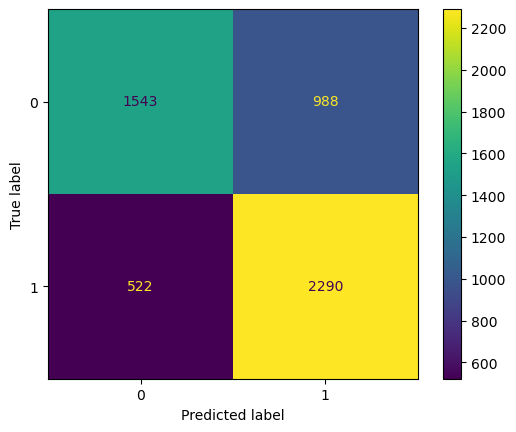

Accuracy:0.717
Precision:0.699
Recall:0.814
F1 Score:0.752


In [45]:
conf_matrix_plot(rf_val.best_estimator_, X_val, y_val)

## Experiment 3: Gradient boosting (XGBOOST)

#### In this experiment , let's use another tree-based ensemble model  ,  XGBOOST  

In [46]:
#Instantiate XGBOOST classifier
xgb = XGBClassifier(objective='binary:logistic' , random_state=0)

In [47]:
# Determine set of hyperparameters for XGBOOST
xgb_cv_params = {'max_depth': [4, 6],
              'min_child_weight': [3, 5],
              'learning_rate': [0.1, 0.2, 0.3],
              'n_estimators': [5,10,15],
              'subsample': [0.7],
              'colsample_bytree': [0.7]
              }

scoring = ['accuracy', 'precision', 'recall', 'f1']

In [48]:
%%time
xgb_cv = GridSearchCV(xgb,
                      xgb_cv_params,
                      scoring = scoring,
                      cv = custom_split,
                      refit = 'f1'
                     )

# Fit the model
xgb_cv.fit(X_train, y_train)

CPU times: total: 16 s
Wall time: 1.26 s


GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0, -1, ...,  0,  0])),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     i...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [4, 6],
                         'min_child_weight': [3, 5],
                         'n_estimators': [5, 10, 15], 'subsample': [0.7]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [49]:
#getting the best paramaters to be used with XGBOOST
xgb_cv.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 10,
 'subsample': 0.7}

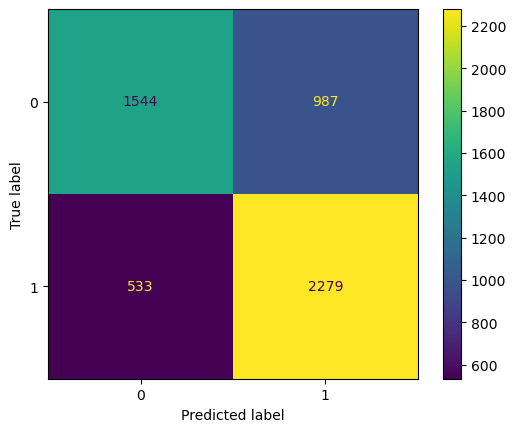

Accuracy:0.716
Precision:0.698
Recall:0.81
F1 Score:0.75


In [50]:
conf_matrix_plot(xgb_cv.best_estimator_, X_val, y_val)

# pacE: Execute Stage

## Step 4. Results and Evaluation

### Summary of model results

#### let's Compare all the alogtithms used together to identify the Champion model

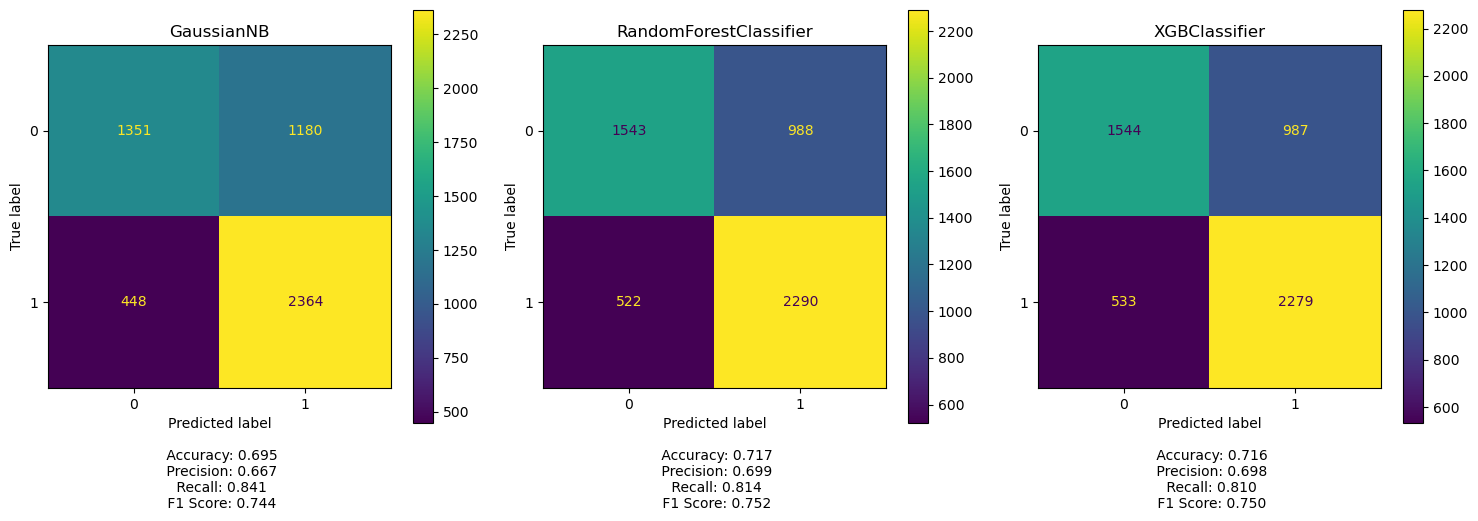

In [51]:
# Collecting our classifiers in a list
classifiers = [Naive_model, rf_val.best_estimator_, xgb_cv.best_estimator_]

# Create a grid of subplots to compare the confusion matrices and accuracy measures
num_classifiers = len(classifiers)

fig, axes = plt.subplots(1, num_classifiers, figsize=(5 * num_classifiers, 5))

# Iterate over each classifier and display its confusion matrix along with its accuracy measures
for i, model in enumerate(classifiers):
    # Compute the confusion matrix
    y_pred = model.predict(X_val)
    cm = confusion_matrix(y_val, y_pred, labels=model.classes_)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=axes[i], values_format='')
    axes[i].set_title(model.__class__.__name__)  # Set the title to the classifier name
    
    # Compute accuracy measures
    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Add text annotations for accuracy measures
    textstr = f' \n \n \n \n \n Accuracy: {acc:.3f}\n Precision: {prec:.3f}\n Recall: {rec:.3f}\n F1 Score: {f1:.3f}'
    axes[i].text(0.5, -0.15, textstr, horizontalalignment='center', verticalalignment='center', transform=axes[i].transAxes)

plt.tight_layout()
plt.show()


# By comparing the results of the three classifiers used , the champion model with f1-score 0.752 ,  is **RandomForest** 🏆🥇

Finally , let's look at the random forest feature importance to identify which features were the most useful for the champion model (random forest)

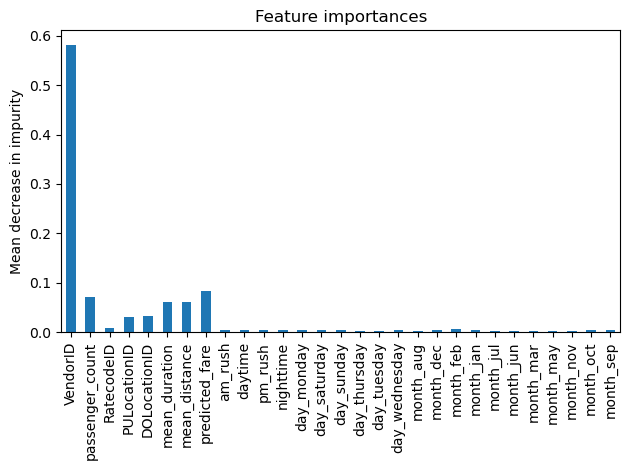

In [53]:
importances = rf_val.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

**vendorID** , **passenger_count** , **PULocationID** , **DOLocationID** ,  **mean_duration** ,  **mean_distance** and **predicted_fare** are the most effective features for random forest classifier

Now let's evaluate the champion model on the unseen test set

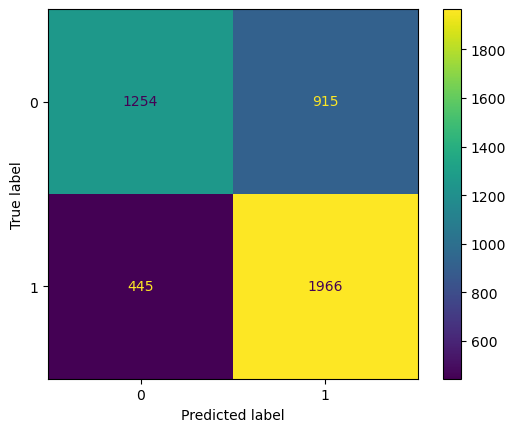

Accuracy:0.703
Precision:0.682
Recall:0.815
F1 Score:0.743


In [54]:
conf_matrix_plot(rf_val.best_estimator_, X_test, y_test)

Not Bad ,right !! ♥️

### Conclusion, Recommendations

- The model performed quite well on validation and test sets , however, it could be improved by doing more feature engineering , In our case, we could try creating three new columns that indicate if the trip distance is short, medium, or far. We could also engineer a column that gives a ratio that represents (the amount of money from the fare amount to the nearest higher multiple of \\$5) / fare amount. For example, if the fare were \\$12, the value in this column would be 0.25, because \\$12 to the nearest higher multiple of \\$5 (\\$15) is \\$3, and \\$3 divided by \\$12 is 0.25. The intuition for this feature is that people might be likely to simply round up their tip, so journeys with fares with values just under a multiple of \\$5 may have lower tip percentages than those with fare values just over a multiple of \\$5. We could also do the same thing for fares to the nearest \\$10. the ratio we are talking about is shown below:

$$
round5\_ratio = \frac{amount\ of\ money\ from\ the\ fare\ amount\ to\ the\ nearest\ higher\ multiple\ of\ \$5}{fare\ amount}
$$

- It would probably be very helpful to have past tipping behavior for each customer. It would also be valuable to have accurate tip values for customers who pay with cash.
It would be helpful to have a lot more data. With enough data, we could create a unique feature for each pickup/dropoff combination.